In [ ]:
import os
import math
import json
import codecs
import cv2 as cv
import numpy as np
import keras.losses
from PIL import Image
from io import BytesIO
import tensorflow as tf
from google.colab import files
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [ ]:
def preprocess():
  def get_pyramid(im,size):
    while im.shape[0]>size[1]+20:
        im = cv.pyrDown(im)
    im = cv.resize(im,size)
    return im

  uploaded = files.upload()
  scale1 = []
  scale2 = []
  scale3 = []

  size = (240*2,320*2)
  for key in uploaded.keys():
    image = Image.open(BytesIO(uploaded[key]))
    image = np.array(image).astype(np.float32)

    if len(image.shape)<3:
     image = cv.cvtColor(image,cv.COLOR_GRAY2RGB)

    image /=255.
    i1 = get_pyramid(image,(240,320))
    i2 = get_pyramid(image,(120,160))
    i3 = get_pyramid(image,(60,80))
    scale1.append(i1)
    scale2.append(i2)
    scale3.append(i3)
  
  scale1 = np.array(scale1)
  scale2 = np.array(scale2)
  scale3 = np.array(scale3)
  return [scale1,scale2,scale3]

In [ ]:
def visualize_heatmap(images,map,index,key_point,all=False,resize=False):
  """
  Args:
    image: an array of (B,W,H,C)
    map: an array of (B,W,H,K) where key is the number of key-points
    index: an index for the image
    key_point: an index for the key_point
  """

  heatmap = None
  image = images[index]

  if all:
    ## Generating complete heatmap
    ### when generating all use non-max_suppression
    ### make sure each keypoint has constant intensity value
    complete_map = np.zeros((map.shape[1],map.shape[2]))

    for i in range(map.shape[-1]):
      minimap = map[index,:,:,i].copy()

      max_value = minimap.max()
      
      minimap[minimap<max_value]=0
      r = tf.argmax(tf.argmax(minimap,axis=1))
      c = tf.argmax(tf.argmax(minimap,axis=0))
      minimap[r,c] = 1.0
      complete_map+=minimap

    heatmap = complete_map
  else:
    heatmap = map[index,:,:,key_point]
  
  if resize:
    heatmap = np.expand_dims(heatmap,-1)
    heatmap = tf.image.resize(heatmap,[image.shape[0],image.shape[1]])
    heatmap = np.squeeze(heatmap,axis=-1)

  fig, axes = plt.subplots(1, 2, figsize=(20, 10))
  ax = axes.ravel()

  ax[0].imshow(image)
  ax[0].set_title("Original")

  ax[1].imshow(image, vmin=0, vmax=2)
  ax[1].imshow(heatmap, alpha=0.7,cmap="gray")
  ax[1].set_title("Original + heatmap")

  fig.tight_layout()
  plt.show()
  plt.figure(figsize=(20,20))

In [ ]:
def pj_error_wrapper(kp,deform_count,category=0):
  def projection_error(y_true,y_pred):
    
    deformations = list()

    if category == 0:
      mean_shape =  np.array([[-1,-1,2],
                           [ 1,-1,2],
                           [1,-1,-2],
                           [-1,-1,-2],
                           [-1,0,2],
                           [1,0,2], 
                           [1,0,-2], 
                           [-1,0,-2],
                           [-1,1,-2],
                           [1,1,-2]],dtype=np.float32)

      d0 = np.array([[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,-1]])
      d1 = np.array([[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0]])
      d2 = np.array([[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
      d3 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0]])

      deformations.append(d0)
      deformations.append(d1)
      deformations.append(d2)
      deformations.append(d3)

    elif category == 1:
      mean_shape = np.array([[-1,-2,1],
                            [1,-2,1],
                            [1,-2,-1],
                            [-1,-2,-1],
                            [-1,0,1],
                            [1,0,1],
                            [1,0,-1],
                            [-1,0,-1],
                            [-1,2,-1],
                            [1,2,-1]],dtype=np.float32)

      d0 = np.array([[0,-1,0],[0,-1,0],[0,-1.,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0], [0,0,0],[0,0,0]])
      d1 =  np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0.,0],[0,0,0],[0,1,0],[0,1,0]])
      d2 = np.array([[-1.,0,0],[1.,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0]])
      d3 =  np.array([[-1.,0,1],[1,0,1],[1,0,-1],[-1.,0,-1],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])

      deformations.append(d0)
      deformations.append(d1)
      deformations.append(d2)
      deformations.append(d3)
      
    elif category == 2:
      mean_shape = np.array([[-2,-2,1],
                          [2,-2,1],
                          [2,-2,-1],
                          [-2,-2,-1],
                          [-2,0,1], 
                          [2,0,1],
                          [2,0,-1],
                          [-2,0,-1],
                          [-2,2,-1],
                          [2,2,-1],
                          [-2,1,-1],
                          [-2,1,1],
                          [2,1,-1],
                          [2,1,1]],dtype=np.float32)
      
      d0 = np.array([[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,1],[0,0,-1],[0,0,1]])
      d1 = np.array([[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0]])
      d2 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0],[0,0.5,0],[0,0.5,0],[0,0.5,0],[0,0.5,0]])
      d3 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0]])
      d4 = np.array([[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
      d5 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,-1],[0,0,0],[0,0,-1]])

      deformations.append(d0)
      deformations.append(d1)
      deformations.append(d2)
      deformations.append(d3)
      deformations.append(d4)
      deformations.append(d5)

    elif category == 3:
      scale=1.2
      mean_shape = np.array([[0.309*scale,-1.5,0.9511*scale],
                            [-0.809*scale,-1.5,0.5878*scale],
                            [-0.809*scale,-1.5,-0.5878*scale], 
                            [0.309*scale,-1.5,-0.9511*scale],
                            [1*scale,-1.5,0.0000*scale],
                            [0,-1.5,0],
                            [0,0,0],
                            [-1,0,1],
                            [1,0,1],
                            [1,0,-1],
                            [-1,0,-1],
                            [-1,1.5,-1],
                            [1,1.5,-1]],dtype=np.float32)
    
      edges = [[1,6],[2,6],[3,6],[4,6],[5,6],[6,7],[8,9],[9,10],[8,11],[10,11],[11,12],[12,13],[10,13]]
      d0 = np.array([[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
      d1 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0]])
      d2 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0]])
      d3 = np.array([[0.309,0,0.9511],[-0.809,0,0.5878],[-0.809,0,-0.5878],[0.309,0,-0.9511],[1,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
      d4 = np.array([[-0.9511,0,0.309],[-0.5878,0,-0.809],[0.5878,0,-0.809],[0.9511,0,0.309],[0,0,1],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
      d5 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])

      deformations.append(d0)
      deformations.append(d1)
      deformations.append(d2)
      deformations.append(d3)
      deformations.append(d4)
      deformations.append(d5)
      
    data = y_pred
    loss=0
    for i in range(data.shape[0]):
      y_pred=data[i]
      weights,R,focus = y_pred[:deform_count],y_pred[deform_count:deform_count+9],y_pred[deform_count+9]  
      R = tf.reshape(R,[3,3])

      weighted_shape = mean_shape.copy()
      for k in range(len(deformations)):
        weighted_shape +=(weights[k]*deformations[k])
    
      points = tf.transpose(weighted_shape)

      points = tf.matmul(R,points)

      points = tf.stack([points[0],points[1],points[2]-10])
      points = points/((1/focus)*points[2]+1)##projection

      points = points[0:2]
      points = tf.transpose(points)

      points = tf.reshape(points,[kp*2])

      loss += tf.keras.losses.mean_squared_logarithmic_error(y_true[i],points)#tf.losses.mean_squared_error(y_true[i],points)
    return loss/data.shape[0]

  return projection_error

In [ ]:
def avg_error(y_true,y_pred):
  key_points_error = []

  for i in range(y_pred.shape[-1]):
    key_points_error.append(0)

  key_points_error = np.array(key_points_error)

  for i in range(y_pred.shape[0]):
    prediction = y_pred[i]
    ground_truth = y_true[i]

    for k in range(prediction.shape[-1]):
      pred_map = prediction[:,:,k].numpy()
      truth_map = ground_truth[:,:,k].numpy()

      r_pred,c_pred = np.unravel_index(pred_map.argmax(),pred_map.shape)
      r_true,c_true = np.unravel_index(truth_map.argmax(),truth_map.shape)
      
      dy = tf.abs(r_true-r_pred)
      dx = tf.abs(c_true-c_pred)
      error = dx+dy
      key_points_error[k]+=error

  avg_error = key_points_error/y_pred.shape[-1]
  return (tf.reduce_sum(avg_error)/y_pred.shape[0]) ## average error of all key_points

In [ ]:
def extract_keypoints(heatmap,path_index):
  points = []
  for k in range(heatmap.shape[-1]):
    pred_map = heatmap[:,:,k]
    r_pred,c_pred = np.unravel_index(pred_map.argmax(),pred_map.shape)
    points.append([c_pred,r_pred])
  
  points = np.expand_dims(np.array(points),axis=0).astype(np.float32)
  XP = points.copy()
  
  if path_index == 0:
    XP[:,0] = points[:,1].copy()
    XP[:,1] = points[:,6].copy()
    XP[:,2] = points[:,5].copy()
    XP[:,3] = points[:,0].copy()
    XP[:,4] = points[:,3].copy()
    XP[:,5] = points[:,8].copy()
    XP[:,6] = points[:,7].copy()
    XP[:,7] = points[:,2].copy()
    XP[:,8] = points[:,4].copy()

  elif path_index == 2:
    XP[:,0] = points[:,1].copy()
    XP[:,1] = points[:,8].copy()
    XP[:,2] = points[:,7].copy()
    XP[:,3] = points[:,0].copy()
    XP[:,4] = points[:,3].copy()
    XP[:,5] = points[:,10].copy()
    XP[:,6] = points[:,9].copy()
    XP[:,7] = points[:,2].copy()
    XP[:,8] = points[:,6].copy()
    XP[:,9] = points[:,13].copy()
    XP[:,10] = points[:,4].copy()
    XP[:,11] = points[:,5].copy()
    XP[:,12] = points[:,11].copy()
    XP[:,13] = points[:,12].copy()


  XP[:,:,0]/=15
  XP[:,:,0]-=1

  XP[:,:,1]/=20
  XP[:,:,1]-=1
  
  return XP

In [ ]:
def inspect(weights,rotation,focus,groundtruth,refine=False,category=0):

  line_thickness = 1
  image  = np.full((80,80,3),255,dtype=np.float32)## creation of white image
  
  deformations = list()
  if category == 0:
    mean_shape =  np.array([[-1,-1,2],
                            [1,-1,2],
                            [1,-1,-2],
                            [-1,-1,-2],
                            [-1,0,2],
                            [1,0,2], 
                            [1,0,-2],
                            [-1,0,-2],
                            [-1,1,-2],
                            [1,1,-2]],dtype=np.float32)
    
    edges = [[1,5],[2,6],[3,7],[4,8],[3,4],[5,6],[6,7],[7,8],[5,8],[8,9],[7,10],[9,10]]

    d0 = np.array([[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,-1]])
    d1 = np.array([[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0]])
    d2 = np.array([[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
    d3 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0]])

    deformations.append(d0)
    deformations.append(d1)
    deformations.append(d2)
    deformations.append(d3)

  elif category == 1:
    mean_shape = np.array([[-1,-2,1],
                          [1,-2,1],
                          [1,-2,-1],
                          [-1,-2,-1],
                          [-1,0,1],
                          [1,0,1],
                          [1,0,-1],
                          [-1,0,-1],
                          [-1,2,-1],
                          [1,2,-1]],dtype=np.float32)
    
    edges = [[1,5],[2,6],[3,7],[4,8],[5,6],[6,7],[7,8],[5,8],[8,9],[7,10],[9,10]]

    d0 = np.array([[0,-1,0],[0,-1,0],[0,-1.,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0], [0,0,0],[0,0,0]])
    d1 =  np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0.,0],[0,0,0],[0,1,0],[0,1,0]])
    d2 = np.array([[-1.,0,0],[1.,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0]])
    d3 =  np.array([[-1.,0,1],[1,0,1],[1,0,-1],[-1.,0,-1],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])

    deformations.append(d0)
    deformations.append(d1)
    deformations.append(d2)
    deformations.append(d3)

  elif category == 2:
  
    mean_shape = np.array([[-2,-2,1],
                          [2,-2,1],
                          [2,-2,-1],
                          [-2,-2,-1],
                          [-2,0,1], 
                          [2,0,1],
                          [2,0,-1],
                          [-2,0,-1],
                          [-2,2,-1],
                          [2,2,-1],
                          [-2,1,-1],
                          [-2,1,1],
                          [2,1,-1],
                          [2,1,1]],dtype=np.float32)
    
    edges = [[1,5],[2,6],[3,7],[4,8],[5,6],[6,7],[7,8],[5,8],[8,9],[7,10],[9,10],[11,12],[12,5],[13,14],[14,6]]
    d0 = np.array([[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,1],[0,0,1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,-1],[0,0,1],[0,0,-1],[0,0,1]])
    d1 = np.array([[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0],[1,0,0]])
    d2 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0],[0,0.5,0],[0,0.5,0],[0,0.5,0],[0,0.5,0]])
    d3 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0],[0,1,0],[0,1,0]])
    d4 = np.array([[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
    d5 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,-1],[0,0,0],[0,0,-1]])

    deformations.append(d0)
    deformations.append(d1)
    deformations.append(d2)
    deformations.append(d3)
    deformations.append(d4)
    deformations.append(d5)

  elif category == 3:
    scale=1.2
    mean_shape = np.array([[0.309*scale,-1.5,0.9511*scale],
                          [-0.809*scale,-1.5,0.5878*scale],
                          [-0.809*scale,-1.5,-0.5878*scale], 
                          [0.309*scale,-1.5,-0.9511*scale],
                          [1*scale,-1.5,0.0000*scale],
                          [0,-1.5,0],
                          [0,0,0],
                          [-1,0,1],
                          [1,0,1],
                          [1,0,-1],
                          [-1,0,-1],
                          [-1,1.5,-1],
                          [1,1.5,-1]],dtype=np.float32)
  
    edges = [[1,6],[2,6],[3,6],[4,6],[5,6],[6,7],[8,9],[9,10],[8,11],[10,11],[11,12],[12,13],[10,13]]
    d0 = np.array([[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,-1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
    d1 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,1,0]])
    d2 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[-1,0,0],[1,0,0],[1,0,0],[-1,0,0],[-1,0,0],[1,0,0]])
    d3 = np.array([[0.309,0,0.9511],[-0.809,0,0.5878],[-0.809,0,-0.5878],[0.309,0,-0.9511],[1,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
    d4 = np.array([[-0.9511,0,0.309],[-0.5878,0,-0.809],[0.5878,0,-0.809],[0.9511,0,0.309],[0,0,1],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])
    d5 = np.array([[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,1,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0],[0,0,0]])

    deformations.append(d0)
    deformations.append(d1)
    deformations.append(d2)
    deformations.append(d3)
    deformations.append(d4)
    deformations.append(d5)

  for i in range(len(deformations)):
    mean_shape+= (weights[i]*deformations[i])

  points = mean_shape.T
  R = rotation.reshape((3,3))
  points = np.dot(R,points) ## Rx+T

  
  points[2]-=10
  threeD = points.copy()
  points = points/((1/focus)*points[2]+1)

  points[0,:]+=1
  points[0,:]*=35
  points[1,:]+=1
  points[1,:]*=35
  points[0]+=5
  points[1]+=5
  points = points.T

  for edge in edges:
      p1 = points[edge[0]-1]
      p2 = points[edge[1]-1]
      
      if refine:
        if category == 1:
          # if edge == [9,10]:
          #   p1[1] = p2[1]-0.5
            # p2[1] = p
          if edge in [[7,10],[3,7],[1,5],[2,6],[8,9]]:
            p1[0] = p2[0]
            

      cv.line(image, (round(p1[0]), round(p1[1])), (round(p2[0]), round(p2[1])), (0, 0, 0), thickness=line_thickness)

  fig, axes = plt.subplots(1, 2, figsize=(10, 10))
  ax = axes.ravel()

  ax[0].imshow(image,cmap="gray")
  ax[0].set_title("Constructed")

  ax[1].imshow(groundtruth)
  ax[1].set_title("Ground Truth")
  return threeD

In [ ]:
def get_models(path_index,download=True):
  key_point_model = None
  construction_model = None
  weights_model = None
  support1 = None
  support2 = None
  if path_index == 0:
    if download:
      !wget -O bed_keypoint.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EaHbC2eSqTBLpQG7OSrxU1IBSueKVV1Wt4CBIpa5xFzHNg?e=OwRlYo&download=1"
      !unzip bed_keypoint.zip

      !wget -O bed_construct.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EXX1A4xG4NVOoyGWICqdDnkBdSwzFLFTTXPSMKcUoEtTkA?e=WEKryz&download=1"
      !unzip bed_construct.zip

      !wget -O bed_construct_weights.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EfrZV0ZzZ55JrEeyD2a00zsBwHq5_jBuGwxrkeLq5jYgLw?e=exhnyU&download=1"
      !unzip bed_construct_weights.zip

      !wget -O support.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EcSvRNFvoB9PuNH7knCWEakBQoodFUZD1aczs040Na_pog?e=rruKk7&download=1"
      !unzip support.zip

      !wget -O support2.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EciT6GHEXm5KiwZCyYV8MgMBAAT0Ap82ak5-1bvjeQoxVg?e=eyWpLP&download=1"
      !unzip support2.zip -d "extracted"

    
    key_point_model = load_model("bed_keypoint",custom_objects={'avg_error':avg_error})
    support1 = load_model("bed_keypoint0",custom_objects={'avg_error':avg_error})
    support2 = load_model("extracted/bed_keypoint",custom_objects={'avg_error':avg_error})
    construction_model = load_model("bed_construct",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index)})
    weights_model = load_model("bed_construct_weights",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index)})

  elif path_index == 1:
    if download:
      !wget -O chair_keypoint.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EdDsHXYowZJNmoxvPCc_o9sB4DVA9b95a_LAbpHoQ8HoEQ?e=UfudIX?&download=1"
      !unzip chair_keypoint.zip

      !wget -O chair_construct.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EVK3Eiw8lCROk8SpPzSfH3sBEoIeYOHFuPCERdwnMYrkDg?e=YPRaiU&download=1"
      !unzip chair_construct.zip

      !wget -O chair_construct_weights.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EfLd7MaRXqZNri0PFzDqa3sBl9Y4aVhSvvaHLZFhMjywfQ?e=0ngUW8&download=1"
      !unzip chair_construct_weights.zip

    key_point_model = load_model("chair_keypoint")
    construction_model = load_model("chair_construct",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index)})
    weights_model = load_model("chair_construct_weights",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index) })

  elif path_index == 2:
    if download:
      !wget -O sofa_keypoint.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/ERoZyWvtG5VOsMGQUWSoczUBD31UrJIpZBWsWJvjNsyqrQ?e=NLXaW4&download=1"
      !unzip sofa_keypoint.zip

      !wget -O sofa_construct.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EXQ2hdOPuuJMuqEGEYSMKt8B4C7KD945drHt32sEDP_fzw?e=490zgp&download=1"
      !unzip sofa_construct.zip
    
      !wget -O sofa_weights.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EQf1HbVU1L9MtAV9qulNAsYB9EZfduA5zE7Zkzb_FtFNMQ?e=97A6tn&download=1"
      !unzip sofa_weights.zip

    key_point_model = load_model("sofa_keypoint",custom_objects={'avg_error':avg_error})
    construction_model = load_model("sofa_construct",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index)})
    weights_model = load_model("sofa_construct_weights",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index) })

  elif path_index == 3:
    if download:
      !wget -O swivelchair_keypoint.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/Efq_Oj_W3_dGqBxq2u5fABUBrXPIqLHbFrvCvrRJnnoFVw?e=MwF5tD&download=1"
      !unzip swivelchair_keypoint.zip
      
      !wget -O swivel_construct.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/ERmJGQBIrgpPlcdNPkeDWl4B6PWiBCL-RGIu4mVvVymWAA?e=OQa7l2&download=1"
      !unzip swivel_construct.zip
      
      !wget -O swivel_weights.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/ESr6ubzKIpxOu5wORrxZQisBZv2YOYaspLXzO2zRvDRcLQ?e=1RsblW&download=1"
      !unzip swivel_weights.zip

      !wget -O support.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EaD4feFb7r5JoeEsy4Zdl_EBzxpN5uznIfgINale2jzNjQ?e=HFaFeU&download=1"
      !unzip support.zip

      !wget -O support2.zip "https://msaedueg-my.sharepoint.com/:u:/g/personal/mostafa_ramadan1_msa_edu_eg/EQWd99251m9MprA6J6PT5UABh7mDPFRrkK4w0A5UaeZoyw?e=QMsTbF&download=1"
      !unzip support2.zip

    key_point_model = load_model("swivelchair_keypoint",custom_objects={'avg_error':avg_error})
    support1 = load_model("swivelchair_keypoint1",custom_objects={'avg_error':avg_error})
    support2 = load_model("swivelchair_keypoint2",custom_objects={'avg_error':avg_error})
    construction_model = load_model("swivelchair_construct",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index)})
    weights_model = load_model("swivelchair_construct_weights",custom_objects={'projection_error':pj_error_wrapper(kp,w_ct,path_index) })

  return key_point_model,construction_model,weights_model,support1,support2

***Check Category***

---



In [ ]:
path_index = 3 ## 0 BED, 1 CHAIR, 2 SOFA, 3 SWIVELCHAIR

w_ct = 4
if path_index == 2 or path_index == 3:
  w_ct = 6
if path_index == 2:
  kp = 14
elif path_index == 3:
  kp = 13
elif path_index == 4:
  kp = 8
else:
  kp = 10

resize = True
all = True

In [ ]:
key_point_model,construction_model,weights_model,support1,support2 = get_models(path_index,False)

Saving swivel2.webp to swivel2.webp


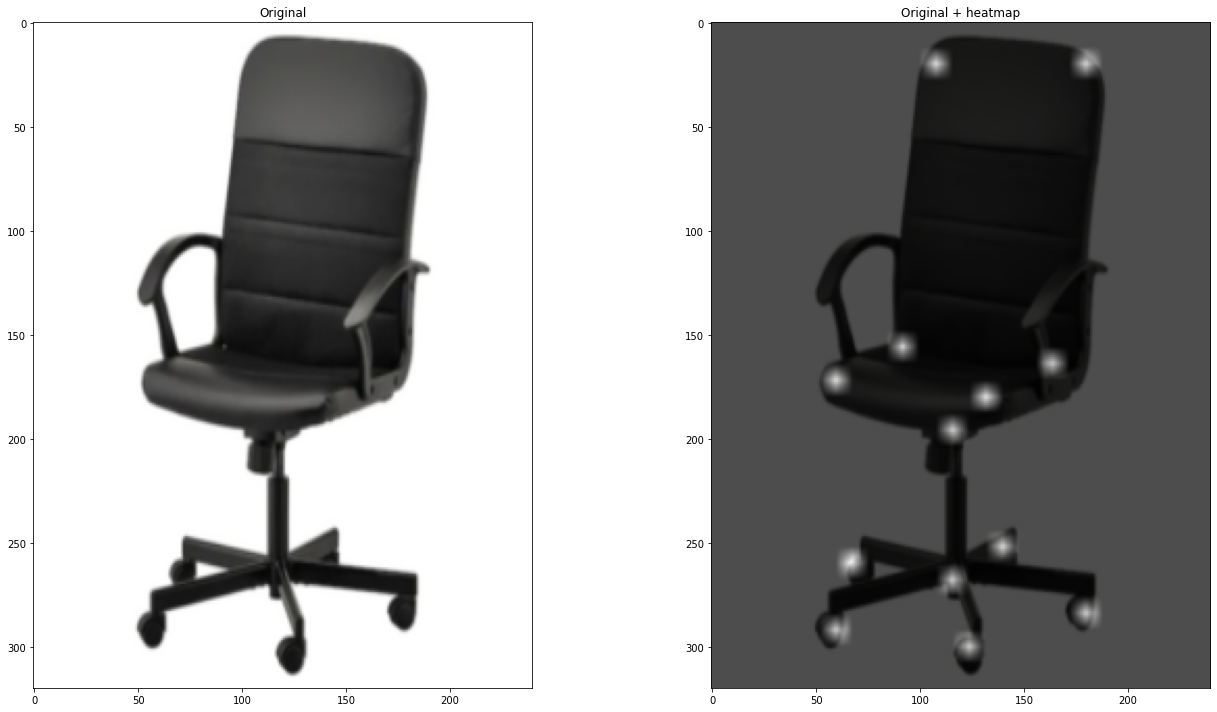

<Figure size 1440x1440 with 0 Axes>

In [ ]:
X = preprocess()
prediction = key_point_model.predict(X)
if support1 is not None:
  pred1 = support1.predict(X)
  prediction = np.add(prediction,pred1)

if support2 is not None:
  pred2 = support2.predict(X)
  prediction = np.add(prediction,pred2)
  
prediction = (prediction-prediction.min())/(prediction.max()-prediction.min())

points = extract_keypoints(np.squeeze(prediction,axis=0),path_index)
points = points.reshape(-1,kp*2)

if resize:
  visualize_heatmap(X[0],prediction,0,-1,all=True,resize=resize)
else:
  image = np.expand_dims(cv.resize(X[2][0],(30,40)),axis=0)
  visualize_heatmap(image,prediction,0,-1,all=True,resize=resize)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


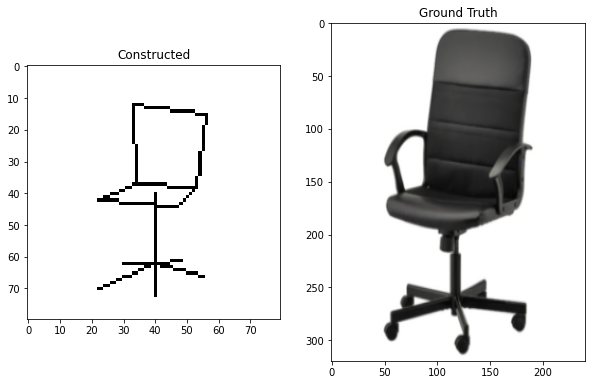

In [ ]:
prediction = construction_model.predict(points)
pred2 = weights_model.predict(points)
if path_index == 3:
  prediction = (prediction+pred2)/2
export = inspect(prediction[0][0:w_ct],prediction[0][w_ct:w_ct+9],prediction[0][w_ct+9],X[0][0],category=path_index,refine=False)
#export = export.T
lists = export.tolist()
json_str = json.dumps(lists)

with open("points.json","w") as file:
   file.write(json_str)

with open("category.txt","w") as file:
   file.write(str(path_index))

In [ ]:
print(export.shape)
export = export.T

(3, 10)


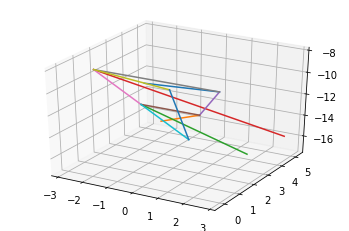

In [ ]:
%matplotlib inline
from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')
edges = [[1,5],[2,6],[3,7],[4,8],[5,6],[6,7],[7,8],[5,8],[8,9],[7,10],[9,10]]
for edge in edges:
    ax.plot([export[0][edge[0]-1], export[0][edge[1]-1]], [export[1][edge[0]-1], export[1][edge[1]-1]],zs=[export[2][edge[0]-1],export[2][edge[1]-1]])